SENTIMENT ANALYSIS - DATA SELECTION

Choose your data source:
4. Upload your own CSV file
5. Enter custom text for analysis

Enter your choice (4-5): 5

CUSTOM TEXT ANALYSIS
Enter texts for analysis (type 'DONE' when finished):

Text 1: /content/positive_reviews.csv

Text 2: done

✅ Dataset loaded: Custom Text Input
📊 Number of samples: 1
📋 Columns: ['text', 'sentiment_label']

Cleaning text data...

Sample data (first 5 rows):
                            text               cleaned_text
0  /content/positive_reviews.csv  contentpositivereviewscsv

Loading pre-trained sentiment model...


Device set to use cpu


Predicting sentiment...

SENTIMENT ANALYSIS RESULTS - Custom Text Input

📈 Sentiment Distribution:
NEGATIVE  :    1 (100.0%)

📊 Top Predictions:

Text: /content/positive_reviews.csv
Sentiment: negative (Confidence: 79.83%)
--------------------------------------------------

Generating visualizations...


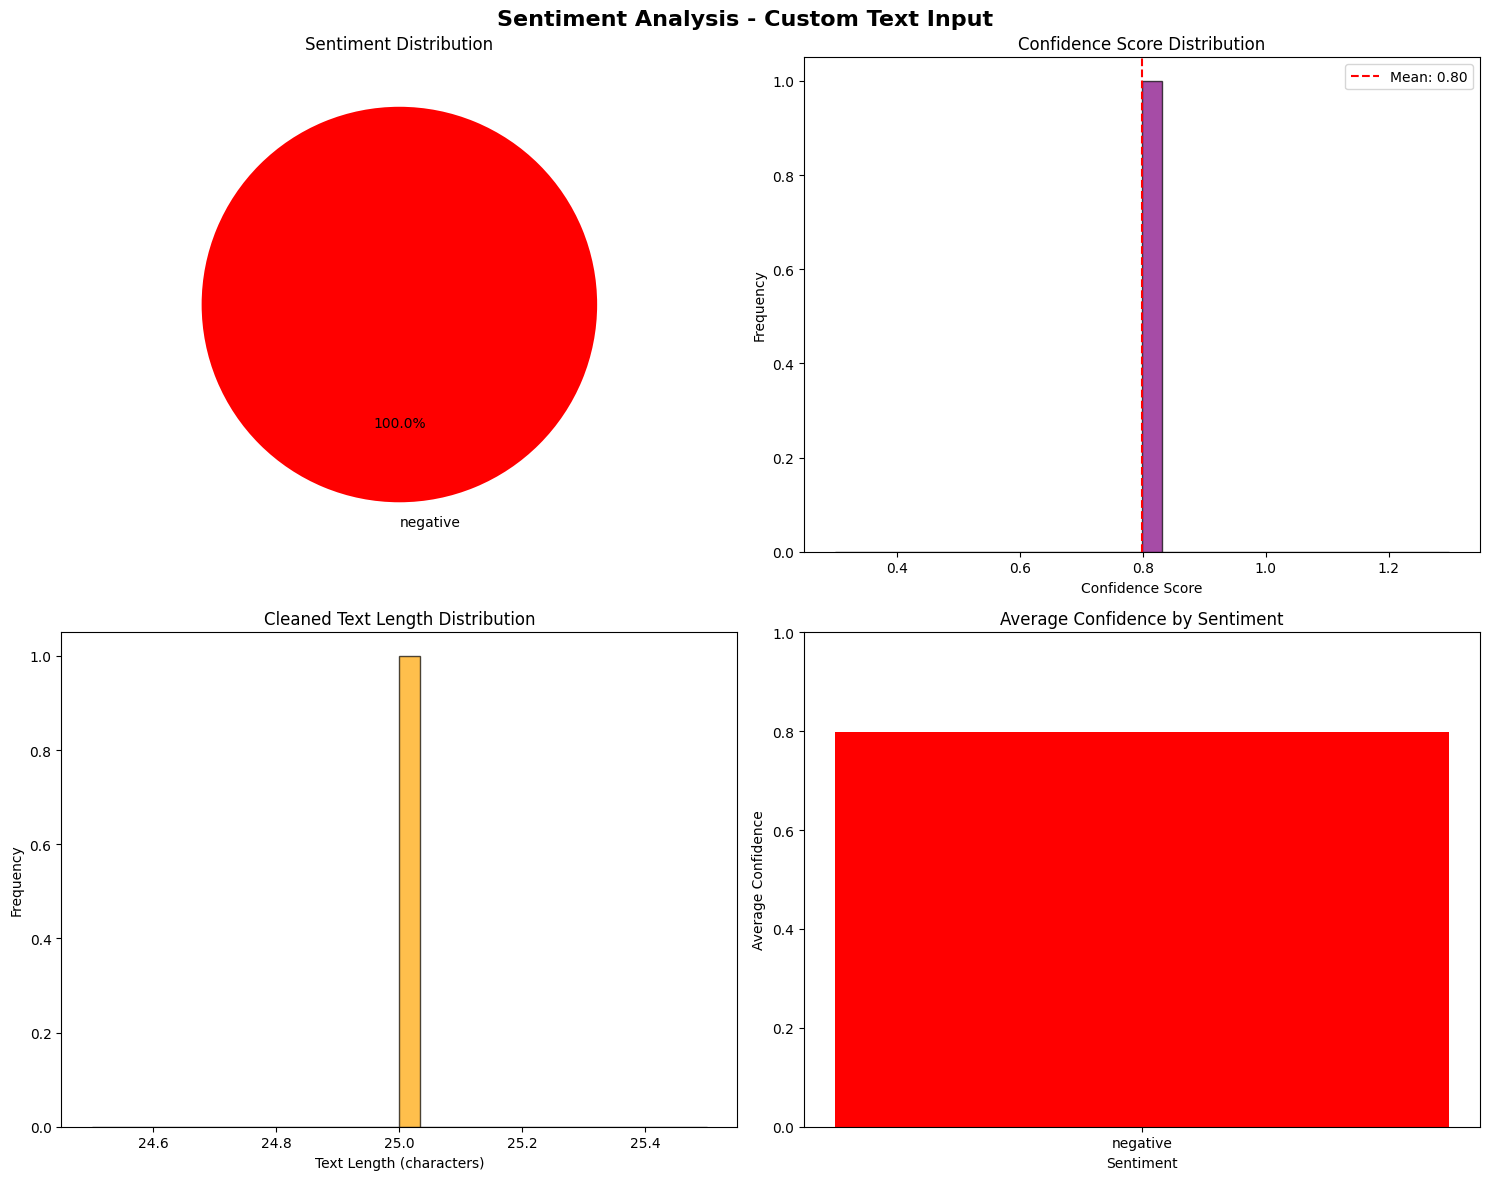


DETAILED INSIGHTS

🎯 Most Confident Prediction (Confidence: 79.83%):
Text: /content/positive_reviews.csv...
Sentiment: negative

⚠️ Most Confident Negative Prediction:
Text: /content/positive_reviews.csv...
Confidence: 79.83%

📊 Average confidence score: 79.83%

✅ ANALYSIS COMPLETE!
📁 Results saved to: sentiment_analysis_Custom_Text_Input.csv
📊 Total samples analyzed: 1

Would you like to analyze more data? (yes/no)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import warnings
import io
import requests
from google.colab import files
warnings.filterwarnings('ignore')

# Step 3: Data Selection Interface
print("=" * 60)
print("SENTIMENT ANALYSIS - DATA SELECTION")
print("=" * 60)
print("\nChoose your data source:")
print("4. Upload your own CSV file")
print("5. Enter custom text for analysis")

choice = input("\nEnter your choice (4-5): ")

def upload_csv():
    """Upload custom CSV file"""
    print("Please upload your CSV file...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"File uploaded: {filename}")
        if filename.endswith('.csv'):
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
            # Check required columns
            if 'text' not in df.columns:
                print("Please rename your text column to 'text'")
                # Let user specify column name
                col_name = input("Enter the name of your text column: ")
                if col_name in df.columns:
                    df['text'] = df[col_name]
                else:
                    print("Column not found. Using first column as text.")
                    df['text'] = df.iloc[:, 0]
            return df
    print("No CSV file uploaded. Using Custom Text Input as default.")
    return custom_text_analysis()

def custom_text_analysis():
    """Analyze custom text input"""
    print("\n" + "="*60)
    print("CUSTOM TEXT ANALYSIS")
    print("="*60)

    texts = []
    print("Enter texts for analysis (type 'DONE' when finished):")

    while True:
        text = input(f"\nText {len(texts)+1}: ")
        if text.upper() == 'DONE':
            break
        if text.strip():
            texts.append(text)

    if not texts:
        print("No text entered. Using sample texts.")
        texts = [
            "I love this product! It's amazing!",
            "Terrible experience, would not recommend.",
            "It's okay, nothing special.",
            "The service was excellent and fast.",
            "Waste of money, very disappointed."
        ]

    df = pd.DataFrame({'text': texts})
    df['sentiment_label'] = 'unknown'  # No ground truth for custom text
    return df

# Load selected dataset
if choice == '4':
    df = upload_csv()
    dataset_name = "Custom CSV File"
elif choice == '5':
    df = custom_text_analysis()
    dataset_name = "Custom Text Input"
else:
    print("Invalid choice. Using Custom Text Input as default.")
    df = custom_text_analysis()
    dataset_name = "Custom Text Input"

print(f"\n✅ Dataset loaded: {dataset_name}")
print(f"📊 Number of samples: {len(df)}")
print(f"📋 Columns: {list(df.columns)}")
print("\n" + "="*60)

# Step 4: Data Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix the LookupError

stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Clean text data"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    """Remove stopwords from text"""
    if not text:
        return ""
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

print("Cleaning text data...")
df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

print("\nSample data (first 5 rows):")
print(df[['text', 'cleaned_text']].head())

# Step 5: Load pre-trained sentiment analysis model
print("\nLoading pre-trained sentiment model...")
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline("sentiment-analysis", model=model_name)

# Step 6: Predict sentiment on cleaned text
print("Predicting sentiment...")

def predict_sentiment(text):
    """Predict sentiment for a given text"""
    if not text or len(text.strip()) == 0:
        return {'label': 'NEUTRAL', 'score': 0.5}
    # Truncate to model max length
    truncated_text = text[:512]
    try:
        result = classifier(truncated_text)
        return result[0]
    except:
        return {'label': 'NEUTRAL', 'score': 0.5}

df['prediction'] = df['cleaned_text'].apply(predict_sentiment)
df['predicted_label'] = df['prediction'].apply(lambda x: x['label'])
df['confidence'] = df['prediction'].apply(lambda x: x['score'])

# Map to consistent labels
df['predicted_sentiment'] = df['predicted_label'].map({
    'POSITIVE': 'positive',
    'NEGATIVE': 'negative',
    'NEUTRAL': 'neutral',
    'LABEL_0': 'negative',
    'LABEL_1': 'positive'
})

# Step 7: Display sample predictions
print("\n" + "="*60)
print(f"SENTIMENT ANALYSIS RESULTS - {dataset_name}")
print("="*60)

print(f"\n📈 Sentiment Distribution:")
sentiment_counts = df['predicted_sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{sentiment.upper():<10}: {count:>4} ({percentage:.1f}%)")

print("\n📊 Top Predictions:")
sample_size = min(10, len(df))
sample_df = df.sample(sample_size, random_state=42)

for idx, row in sample_df.iterrows():
    text_preview = row['text'][:80] + "..." if len(row['text']) > 80 else row['text']
    print(f"\nText: {text_preview}")
    print(f"Sentiment: {row['predicted_sentiment']} (Confidence: {row['confidence']:.2%})")
    print("-" * 50)

# Step 8: Visualize results
print("\nGenerating visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Sentiment Analysis - {dataset_name}', fontsize=16, fontweight='bold')

# 1. Sentiment distribution pie chart
sentiment_counts = df['predicted_sentiment'].value_counts()
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
color_list = [colors.get(sent, 'blue') for sent in sentiment_counts.index]

axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index,
               autopct='%1.1f%%', colors=color_list, startangle=90)
axes[0, 0].set_title('Sentiment Distribution')

# 2. Confidence distribution
axes[0, 1].hist(df['confidence'], bins=30, color='purple', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Confidence Score Distribution')
axes[0, 1].set_xlabel('Confidence Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['confidence'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["confidence"].mean():.2f}')
axes[0, 1].legend()

# 3. Text length distribution
df['text_length'] = df['cleaned_text'].apply(len)
axes[1, 0].hist(df['text_length'], bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Cleaned Text Length Distribution')
axes[1, 0].set_xlabel('Text Length (characters)')
axes[1, 0].set_ylabel('Frequency')

# 4. Sentiment vs Confidence
sentiment_groups = df.groupby('predicted_sentiment')['confidence'].mean()
axes[1, 1].bar(sentiment_groups.index, sentiment_groups.values,
               color=[colors.get(sent, 'blue') for sent in sentiment_groups.index])
axes[1, 1].set_title('Average Confidence by Sentiment')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Average Confidence')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Step 9: Detailed Insights
print("\n" + "="*60)
print("DETAILED INSIGHTS")
print("="*60)

# Most positive text
most_positive = df.loc[df['confidence'].idxmax()]
print(f"\n🎯 Most Confident Prediction (Confidence: {most_positive['confidence']:.2%}):")
print(f"Text: {most_positive['text'][:150]}...")
print(f"Sentiment: {most_positive['predicted_sentiment']}")

# Most negative text
negative_df = df[df['predicted_sentiment'] == 'negative']
if len(negative_df) > 0:
    most_negative = negative_df.loc[negative_df['confidence'].idxmax()]
    print(f"\n⚠️ Most Confident Negative Prediction:")
    print(f"Text: {most_negative['text'][:150]}...")
    print(f"Confidence: {most_negative['confidence']:.2%}")

# Average confidence
print(f"\n📊 Average confidence score: {df['confidence'].mean():.2%}")

# Check if we have ground truth for accuracy
if 'sentiment_label' in df.columns and df['sentiment_label'].nunique() > 1:
    # Calculate accuracy for labeled data
    labeled_df = df[df['sentiment_label'] != 'unknown']
    if len(labeled_df) > 0:
        # Simple matching (positive/negative)
        def map_to_binary(sentiment):
            if 'pos' in str(sentiment).lower():
                return 'positive'
            elif 'neg' in str(sentiment).lower():
                return 'negative'
            else:
                return str(sentiment).lower()

        labeled_df['actual_binary'] = labeled_df['sentiment_label'].apply(map_to_binary)
        labeled_df['predicted_binary'] = labeled_df['predicted_sentiment']

        # Calculate accuracy
        correct = (labeled_df['actual_binary'] == labeled_df['predicted_binary']).sum()
        accuracy = correct / len(labeled_df)
        print(f"\n🎯 Model Accuracy on Labeled Data: {accuracy:.2%}")
        print(f"   Correct: {correct}/{len(labeled_df)}")

# Step 10: Save results
output_filename = f"sentiment_analysis_{dataset_name.replace(' ', '_')}.csv"
df.to_csv(output_filename, index=False)

print("\n" + "="*60)
print(f"✅ ANALYSIS COMPLETE!")
print(f"📁 Results saved to: {output_filename}")
print(f"📊 Total samples analyzed: {len(df)}")
print("="*60)

# Step 11: Option to analyze more data
print("\nWould you like to analyze more data? (yes/no)")
continue_choice = input().lower()
if continue_choice in ['yes', 'y']:
    print("\nRestarting analysis...")
    # You could restart the analysis here by calling the main function again
else:
    print("\nThank you for using the Sentiment Analysis tool!")
    print("🎓 Task 4: Sentiment Analysis - COMPLETED!")